In [2]:
 !pip install pytorch torchvision torchaudio

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
    --------------------------------------- 0.0/1.2 MB 682.7 kB/s eta 0:00:02
   - -------------------------------------- 0.0/1.2 MB 393.8 kB/s eta 0:00:03
   ---- ----------------------------------- 0.1/1.2 MB 901.1 kB/s eta 0:00:02
   -------- ------------------------------- 0.2/1.2 MB 1.3 MB/s eta 0:00:01
   -------------- ------------------------- 0.4/1.2 MB 1.9 MB/s eta 0:00:01
   --------------------- ------------------ 0.6/1.2 MB 2.3 MB/s eta 0:00:01
   ------------------------- -------------- 0.7/1.2 MB 2.4 MB/s eta 0:00:01
   ------------------------------- -------- 0.9/1.2 MB 2.7 MB/s eta 0:00:01
   ----------------------------------- ---- 1.0/1.2 MB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 2.7 MB/s eta 0:

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Rohit\AppData\Local\Temp\pip-install-eutweux8\pytorch_f324ffa9130c46ad8454c0712049d11d\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [3]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html
     ---------------------------------------- 0.0/717.9 kB ? eta -:--:--
     -- ---------------------------------- 41.0/717.9 kB 960.0 kB/s eta 0:00:01
     ------- ------------------------------ 143.4/717.9 kB 1.7 MB/s eta 0:00:01
     ----------- -------------------------- 225.3/717.9 kB 1.7 MB/s eta 0:00:01
     ---------------------- --------------- 430.1/717.9 kB 2.4 MB/s eta 0:00:01
     -------------------------------- ----- 614.4/717.9 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 717.9/717.9 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/336.7 kB ? eta -:--:--
     -------------------------------------- 336.7/336.7 kB 6.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/793.1 kB ? eta -:--:--
     ---------- --------------------------- 215.0/793.1 kB 6.6 MB/s eta 0:00:01
     ---------------------- --------------- 471.0/793.1 kB 5.9 MB/s eta 0:00:

In [4]:
!pip install torch_geometric

In [5]:
!pip install python-louvain

In [35]:
!pip uninstall torch-geometric

^C


In [75]:
import numpy as np
import pandas as pd
import torch
import networkx as nx
import itertools
from torch_geometric.utils import to_scipy_sparse_matrix, from_networkx
from community import community_louvain
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, AGNNConv
from torch_geometric.loader import NeighborLoader
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm
import importlib
import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import ipdb
# from google.colab import drive
# drive.mount('/mnt/drive')

In [2]:
importlib.reload(metrics)

<module 'metrics' from 'e:\\MSDS Course\\Spring 2024\\CSE 547 ML for Big Data\\FinalProject\\RedditCommunityDetection\\metrics.py'>

In [3]:
subreddit_hyperlinks = pd.read_csv("soc-redditHyperlinks-body.tsv", delimiter="\t")

In [4]:
subreddit_categories = pd.read_csv("reddit_categoriesv2.csv")

In [5]:
subreddit_categories['Names'] = subreddit_categories['Names'].astype(str)

In [ ]:
subreddit_categories

In [6]:
subreddit_embeddings = pd.read_csv("subreddit_embeddings.csv", header=None)
subreddit_embeddings.columns = ['subreddit'] + [f'embedding_{i}' for i in range(300)]

In [7]:
subreddits = list(set(set(subreddit_hyperlinks['SOURCE_SUBREDDIT']).union(set(subreddit_hyperlinks['TARGET_SUBREDDIT']))))
print(f"Total {len(subreddits)} unique subreddits from the edge hyperlinks")

Total 35776 unique subreddits from the edge hyperlinks


In [8]:
subreddit_names_set = set(subreddit_categories['Names'])
fin_subreddit_names = list(set(subreddit_embeddings['subreddit']).intersection(set(subreddits)))
fin_subreddit_names = [name for name in fin_subreddit_names if name in subreddit_names_set]
print(f"We have subreddit embeddings for {len(fin_subreddit_names)} unique subreddits")

We have subreddit embeddings for 21206 unique subreddits


In [9]:
subreddit_embeddings = subreddit_embeddings[subreddit_embeddings['subreddit'].isin(fin_subreddit_names)]

## Creating subreddit name and embedding mapping

In [10]:
subreddit_to_embedding = {row['subreddit']: row[1:].values.tolist() for _, row in subreddit_embeddings.iterrows()}

## FIltering edges for only those subreddits for which we have node embeddings

In [11]:
subreddit_hyperlinks = subreddit_hyperlinks[subreddit_hyperlinks['SOURCE_SUBREDDIT'].isin(fin_subreddit_names) & subreddit_hyperlinks['TARGET_SUBREDDIT'].isin(fin_subreddit_names) ]

## Create subreddit name vs node_id map

In [12]:
subreddit_to_id = {subreddit: idx for idx, subreddit in enumerate(fin_subreddit_names)}
id_to_subreddit = {idx:subreddit for idx, subreddit in enumerate(fin_subreddit_names)}

In [13]:
len(fin_subreddit_names)

21206

## Process subreddit classes

In [14]:
print(subreddit_categories['Category'].value_counts())
subreddit_categories['node_id'] = subreddit_categories['Names'].map(subreddit_to_id)
subredditclass_to_index = {cls: idx for idx, cls in enumerate(subreddit_categories['Category'].unique())}

subreddit_name_to_class = defaultdict(str)
for _, row in subreddit_categories.iterrows():
    subreddit_name_to_class[row['Names']]=row['Category']

Entertainment             4296
Gaming                    3970
News & Education          2660
Technology & Computing    2249
Travel & Geography        1243
Healthy Living            1038
Sports                    1023
Music & Audio              952
Business & Finance         893
Art & Design               717
Family & Relationships     585
Food & Drink               315
Reading                    311
Animals & Pets             289
Automotive                 273
Style & Fashion            264
Television & Film          214
Moods                      174
Toys & Collectibles         66
Industries                  55
Name: Category, dtype: int64


## Create graph

In [15]:
G = nx.Graph()
for name in fin_subreddit_names:
    G.add_node(subreddit_to_id[name], y=subredditclass_to_index[subreddit_name_to_class[name]])

for index, row in subreddit_hyperlinks.iterrows():
    source = subreddit_to_id[row['SOURCE_SUBREDDIT']]
    target = subreddit_to_id[row['TARGET_SUBREDDIT']] #node_ids (indices)
    G.add_edge(source, target)

#add subreddit embeddings to nodes
for node_id in G.nodes:
    G.nodes[node_id]['x'] = subreddit_to_embedding[id_to_subreddit[node_id]]

In [16]:
data = from_networkx(G)

## Performing Stratified split across classes to get training and testing masks

In [17]:
train_ids, test_ids = train_test_split(
    list(G.nodes()), test_size=0.3, stratify=list(nx.get_node_attributes(G, 'y').values()), random_state=42
)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_ids] = True
test_mask[test_ids] = True
data.train_mask = train_mask
data.test_mask = test_mask

## Run Louvain on the graph to get pseudo-labels

In [18]:
#partition = community_louvain.best_partition(G)
partitions = nx.community.louvain_communities(G, resolution=1, seed=123)
partition_dict_louvain = {node_id: i for i, community in enumerate(partitions) for node_id in community}

In [19]:
partition_counts = {community:len(p) for community, p in enumerate(partitions)}

## GraphSAGE Trial

In [27]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model parameters
input_dim = 300
hidden_dim = 256
output_dim = 20

# Initialize the model, loss function, and optimizer
model = GraphSAGE(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Test the model
def test(data):
    model.eval()
    out = model(data)
    _, pred = out[data.test_mask].max(dim=1)
    correct = pred.eq(data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    print(f'Accuracy: {accuracy:.4f}')

# Run the training and testing
train(data)
test(data)

Epoch 0, Loss: 2.978233575820923
Epoch 20, Loss: 1.6531767845153809
Epoch 40, Loss: 1.4821962118148804
Epoch 60, Loss: 1.3855888843536377
Epoch 80, Loss: 1.3282767534255981
Epoch 100, Loss: 1.2894536256790161
Epoch 120, Loss: 1.267521619796753
Epoch 140, Loss: 1.2364091873168945
Epoch 160, Loss: 1.2225289344787598
Epoch 180, Loss: 1.2140306234359741
Accuracy: 0.5970


In [92]:
# class GraphSAGE(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(GraphSAGE, self).__init__()
#         self.conv1 = SAGEConv(input_dim, hidden_dim)
#         self.conv2 = SAGEConv(hidden_dim, output_dim)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

### Training GCN for community classification

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.bn1 = BatchNorm(hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply BatchNorm
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [38]:
# class GAT(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_heads=16):
#         super(GAT, self).__init__()
#         self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=0.6)
#         self.conv2 = GATConv(hidden_dim * num_heads, output_dim, heads=1, concat=False, dropout=0.6)

#     def forward(self, x, edge_index):
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

In [21]:
input_dim = data.x.shape[1]
hidden_dim1 = 128
output_dim = len(set(nx.get_node_attributes(G, 'y').values()))

#model = GAT(input_dim, hidden_dim1, output_dim)
model = GCN(input_dim, hidden_dim1, output_dim)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[500, 500],
    batch_size=1024,
    input_nodes=data.train_mask,
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[500, 500],
    batch_size=1024,
    input_nodes=data.test_mask,
)

In [23]:
def train():
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size

    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    totals = 0
    for batch in loader:
        out = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        totals+=len(batch.y)
    return correct / totals


In [46]:
epochs = 200
best_acc=0
for epoch in range(epochs):
    loss = train()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}')
    if (epoch + 1) % 10 == 0:
        acc = test(test_loader)
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_gcn_model.pth')


Epoch: 001, Loss: 2.0921
Epoch: 002, Loss: 1.7614
Epoch: 003, Loss: 1.6706
Epoch: 004, Loss: 1.6085
Epoch: 005, Loss: 1.5575
Epoch: 006, Loss: 1.5155
Epoch: 007, Loss: 1.4897
Epoch: 008, Loss: 1.4577
Epoch: 009, Loss: 1.4566
Epoch: 010, Loss: 1.4190
Epoch: 010, Loss: 1.4190, Test Acc: 0.5767
Epoch: 011, Loss: 1.4071
Epoch: 012, Loss: 1.4134
Epoch: 013, Loss: 1.3969
Epoch: 014, Loss: 1.3688
Epoch: 015, Loss: 1.3601
Epoch: 016, Loss: 1.3611
Epoch: 017, Loss: 1.3489
Epoch: 018, Loss: 1.3856
Epoch: 019, Loss: 1.3426
Epoch: 020, Loss: 1.3184
Epoch: 020, Loss: 1.3184, Test Acc: 0.6095
Epoch: 021, Loss: 1.3224
Epoch: 022, Loss: 1.3256
Epoch: 023, Loss: 1.3080
Epoch: 024, Loss: 1.3243
Epoch: 025, Loss: 1.3293
Epoch: 026, Loss: 1.3109
Epoch: 027, Loss: 1.2974
Epoch: 028, Loss: 1.3059
Epoch: 029, Loss: 1.3020
Epoch: 030, Loss: 1.2826
Epoch: 030, Loss: 1.2826, Test Acc: 0.6128
Epoch: 031, Loss: 1.3086
Epoch: 032, Loss: 1.2820
Epoch: 033, Loss: 1.2962
Epoch: 034, Loss: 1.2741
Epoch: 035, Loss: 1.2

In [24]:
model.load_state_dict(torch.load('best_gcn_model.pth'))

<All keys matched successfully>

### Training Attention Graph Neural Network

In [76]:
class AGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(AGNN, self).__init__()
        self.lin = torch.nn.Linear(num_node_features, 128)
        self.agnn1 = AGNNConv(requires_grad=True)
        self.agnn2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(128, num_classes)

    def forward(self, x, edge_index):

        x = self.lin(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.agnn1(x, edge_index)
        x = self.agnn2(x, edge_index)
        x = self.lin2(x)

        return F.log_softmax(x, dim=1)

In [77]:
model_agnn = AGNN(num_node_features=input_dim, num_classes=output_dim)
optimizer = Adam(model.parameters(), lr=1e-03, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
epochs = 3000
best_acc = 0
patience = 100
patience_counter = 0

for epoch in range(epochs):
    loss = train()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}')

    if (epoch + 1) % 10 == 0:
        acc = test(test_loader)
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
            print(f'New best accuracy: {best_acc:.4f}')
            torch.save(model.state_dict(), '/content/drive/MyDrive/BigData/best_gcn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered')
            break

print(f'Best Test Accuracy: {best_acc:.4f}')

In [78]:
model_agnn

AGNN(
  (lin): Linear(in_features=300, out_features=128, bias=True)
  (agnn1): AGNNConv()
  (agnn2): AGNNConv()
  (lin2): Linear(in_features=128, out_features=20, bias=True)
)

In [81]:
model_agnn.load_state_dict(torch.load('best_agnn_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### Making predictions on the entire data

In [83]:
model_agnn.eval()
with torch.no_grad():
    _, pred = model_agnn(data.x, data.edge_index).max(dim=1)
AGNN_labels = pred.cpu().numpy()  # Move to CPU before converting to numpy

# Create partition dictionary
partition_dict_AGNN = {}
for id, label in enumerate(AGNN_labels):
    partition_dict_AGNN[id] = label

# Create partition list
output_dim = 20
partition_AGNN = [[] for _ in range(output_dim)]
for key, value in partition_dict_AGNN.items():
    partition_AGNN[value].append(key)

# Count partition sizes
partition_counts_AGNN = {community: len(p) for community, p in enumerate(partition_AGNN)}
print(partition_counts_AGNN)

{0: 695, 1: 369, 2: 323, 3: 4673, 4: 906, 5: 2689, 6: 1130, 7: 54, 8: 124, 9: 989, 10: 184, 11: 2244, 12: 839, 13: 5339, 14: 220, 15: 193, 16: 18, 17: 13, 18: 188, 19: 16}


In [25]:
_, pred = model(data.x, data.edge_index).max(dim=1)
GCN_labels = pred.numpy()
partition_dict_GCN={}
for id, label in enumerate(GCN_labels):
  partition_dict_GCN[id]=label
  partition_GCN = [[] for _ in range (output_dim)]
  
for key, value in partition_dict_GCN.items():
  partition_GCN[value].append(key)

partition_counts_GCN = {community:len(p) for community, p in enumerate(partition_GCN)}
partition_counts_GCN

{0: 746,
 1: 555,
 2: 418,
 3: 4570,
 4: 922,
 5: 2899,
 6: 1100,
 7: 54,
 8: 132,
 9: 1106,
 10: 218,
 11: 1850,
 12: 867,
 13: 5101,
 14: 226,
 15: 204,
 16: 21,
 17: 10,
 18: 205,
 19: 2}

## Calculating Metrics

In [84]:
print(f"Overall GCN community detection accuracy is {accuracy_score(data.y, GCN_labels)}")
print(f"Overall AGNN community detection accuracy is {accuracy_score(data.y, AGNN_labels)}")

Overall GCN community detection accuracy is 0.6369895312647363
Overall AGNN community detection accuracy is 0.6996604734509101


### *Overall community detection accuracy (GCN) is 63.69%*
### *Overall community detection accuracy (AGNN) is 69.96%*

In [27]:
louvain_nmi = normalized_mutual_info_score(data.y, list(partition_dict_louvain.values()))
louvain_modularity = nx.community.modularity(G, partitions)
louvain_coverage = metrics.calculate_coverage(G, partition_dict_louvain)
louvain_density = metrics.calculate_density(G, partition_dict_louvain)
louvain_clustering_coefficient = metrics.calculate_clustering_coefficient(G, partition_dict_louvain)
louvain_conductance = metrics.calculate_conductance(G, partition_dict_louvain)

In [28]:
GCN_nmi = normalized_mutual_info_score(data.y, list(partition_dict_GCN.values()))
GCN_modularity = nx.community.modularity(G, partition_GCN)
GCN_coverage = metrics.calculate_coverage(G, partition_dict_GCN)
GCN_density = metrics.calculate_density(G, partition_dict_GCN)
GCN_clustering_coefficient = metrics.calculate_clustering_coefficient(G, partition_dict_GCN)
GCN_conductance = metrics.calculate_conductance(G, partition_dict_GCN)

In [85]:
AGNN_nmi = normalized_mutual_info_score(data.y, list(partition_dict_AGNN.values()))
AGNN_modularity = nx.community.modularity(G, partition_AGNN)
AGNN_coverage = metrics.calculate_coverage(G, partition_dict_AGNN)
AGNN_density = metrics.calculate_density(G, partition_dict_AGNN)
AGNN_clustering_coefficient = metrics.calculate_clustering_coefficient(G, partition_dict_AGNN)
AGNN_conductance = metrics.calculate_conductance(G, partition_dict_AGNN)

In [86]:
# Compare the metrics
# Compare the metrics for Louvain
print("Louvain Metrics:")
print(f"Normalized Mutual Information (NMI): Louvain - {louvain_nmi}")
print(f"Modularity: Louvain - {louvain_modularity}")
print(f"Coverage: Louvain - {louvain_coverage}")
print(f"Density: Louvain - {louvain_density}")
print(f"Clustering Coefficient: Louvain - {louvain_clustering_coefficient}")
print(f"Conductance: Louvain - {louvain_conductance}")

Louvain Metrics:
Normalized Mutual Information (NMI): Louvain - 0.03798050329552287
Modularity: Louvain - 0.4572560017842113
Coverage: Louvain - 0.6203502987003735
Density: Louvain - 0.8131828369558277
Clustering Coefficient: Louvain - 0.01650944323589908
Conductance: Louvain - 0.017179822675616817


In [87]:
# Compare the metrics for GCN
print("GCN Metrics:")
print(f"Normalized Mutual Information (NMI): GCN - {GCN_nmi}")
print(f"Modularity: GCN - {GCN_modularity}")
print(f"Coverage: GCN - {GCN_coverage}")
print(f"Density: GCN - {GCN_density}")
print(f"Clustering Coefficient: GCN - {GCN_clustering_coefficient}")
print(f"Conductance: GCN - {GCN_conductance}")

GCN Metrics:
Normalized Mutual Information (NMI): GCN - 0.4120788303761107
Modularity: GCN - 0.3775401013667926
Coverage: GCN - 0.5057348436275557
Density: GCN - 0.03237956037026372
Clustering Coefficient: GCN - 0.21554470780381463
Conductance: GCN - 0.583441869229324


In [88]:
# Compare the metrics for AGNN
print("AGNN Metrics:")
print(f"Normalized Mutual Information (NMI): AGNN - {AGNN_nmi}")
print(f"Modularity: AGNN - {AGNN_modularity}")
print(f"Coverage: AGNN - {AGNN_coverage}")
print(f"Density: AGNN - {AGNN_density}")
print(f"Clustering Coefficient: AGNN - {AGNN_clustering_coefficient}")
print(f"Conductance: AGNN - {AGNN_conductance}")

AGNN Metrics:
Normalized Mutual Information (NMI): AGNN - 0.4920752220448988
Modularity: AGNN - 0.34392222951828977
Coverage: AGNN - 0.4882402629784549
Density: AGNN - 0.013925062441847038
Clustering Coefficient: AGNN - 0.18674769931972338
Conductance: AGNN - 0.6362765130841472


## Visualizing

In [72]:
def visualize_sampled_communities(G, partition_dict, num_samples_per_community=50, seed=None):
    if seed is not None:
        np.random.seed(seed)

    num_communities = max(partition_dict.values()) + 1
    colors = cm.rainbow(np.linspace(0, 1, num_communities))

    sampled_nodes = []
    node_colors = []
    
    # Iterate over communities
    for community in range(num_communities):
        community_nodes = [node for node, comm in partition_dict.items() if comm == community]
        
        sampled_nodes.extend(np.random.choice(community_nodes, size=min(num_samples_per_community, len(community_nodes)), replace=False))
        
        node_colors.extend([colors[community]] * min(num_samples_per_community, len(community_nodes)))
    
    # Create a subgraph with the sampled nodes
    subgraph_edges = [(u, v) for u, v in G.edges() if u in sampled_nodes and v in sampled_nodes]
    subgraph = G.edge_subgraph(subgraph_edges)

    subgraph_node_colors = [node_colors[sampled_nodes.index(node)] for node in subgraph.nodes()]

    # Draw the subgraph
    pos = nx.kamada_kawai_layout(subgraph)
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(subgraph, pos, nodelist=subgraph.nodes(), node_color=subgraph_node_colors, node_size=30)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3)

    
    plt.title('Reddit Graph communities Louvain')
    plt.show()


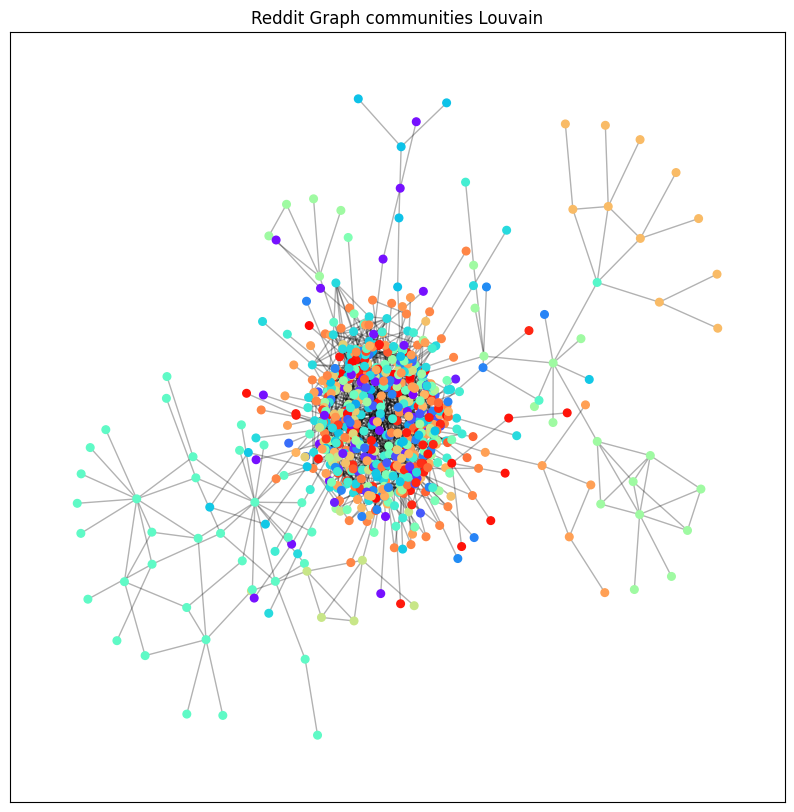

In [74]:
visualize_sampled_communities(G, partition_dict_louvain)

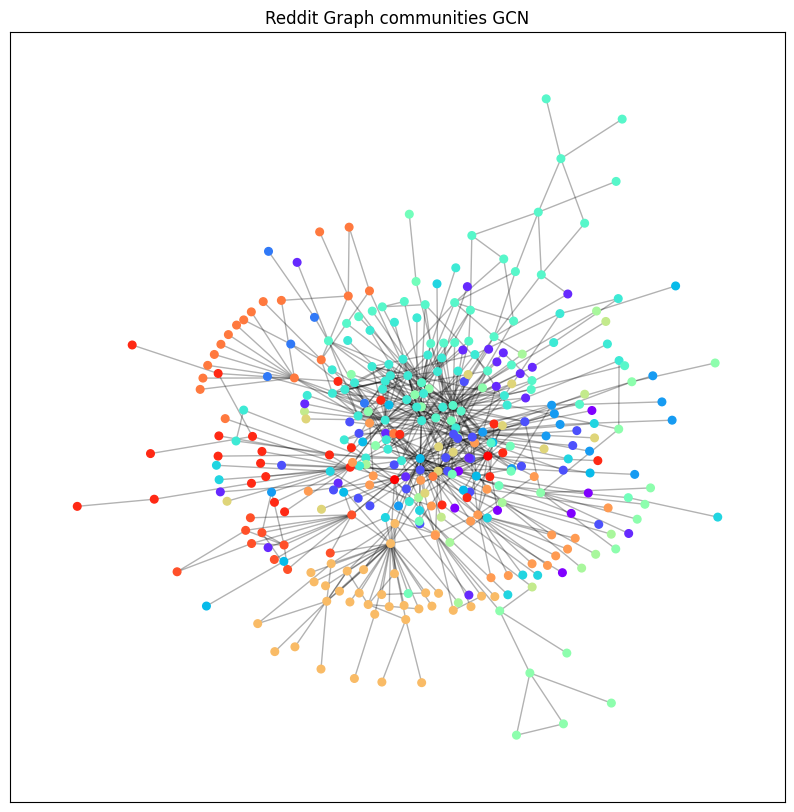

In [71]:
visualize_sampled_communities(G, partition_dict_GCN)